In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Question 2.1

In [2]:
# Hardware constants
SINGLE_PRECISION_PERFORMANCE = 16.3 * 10**12

# Hyperparameters corresponding to the test large in main_q1.cpp
D = 784
H = 512
B = 3200
N = 38400
E = 1 # number of epochs
num_batches = E * (N / B)

points = [
    [1, 0.0586612],
    [2, 0.0844932],
    [4, 0.0981516]
]

for point in points:
    num_procs, dt = point
    FLOPs_per_batch = 4 * D * H * B
    total_FLOPs = FLOPs_per_batch * num_batches
    FLOPs_per_sec = total_FLOPs / dt
    utilization = FLOPs_per_sec / (num_procs * SINGLE_PRECISION_PERFORMANCE)
    print(f"Number of processes: {num_procs}")
    print(f"Total FLOPs: {total_FLOPs:.2e}")
    print(f"Total time: {dt:.4f} seconds")
    print(f"Compute utilization: {utilization * 100:.4f}%\n")

Number of processes: 1
Total FLOPs: 6.17e+10
Total time: 0.0587 seconds
Compute utilization: 6.4482%

Number of processes: 2
Total FLOPs: 6.17e+10
Total time: 0.0845 seconds
Compute utilization: 2.2384%

Number of processes: 4
Total FLOPs: 6.17e+10
Total time: 0.0982 seconds
Compute utilization: 0.9635%



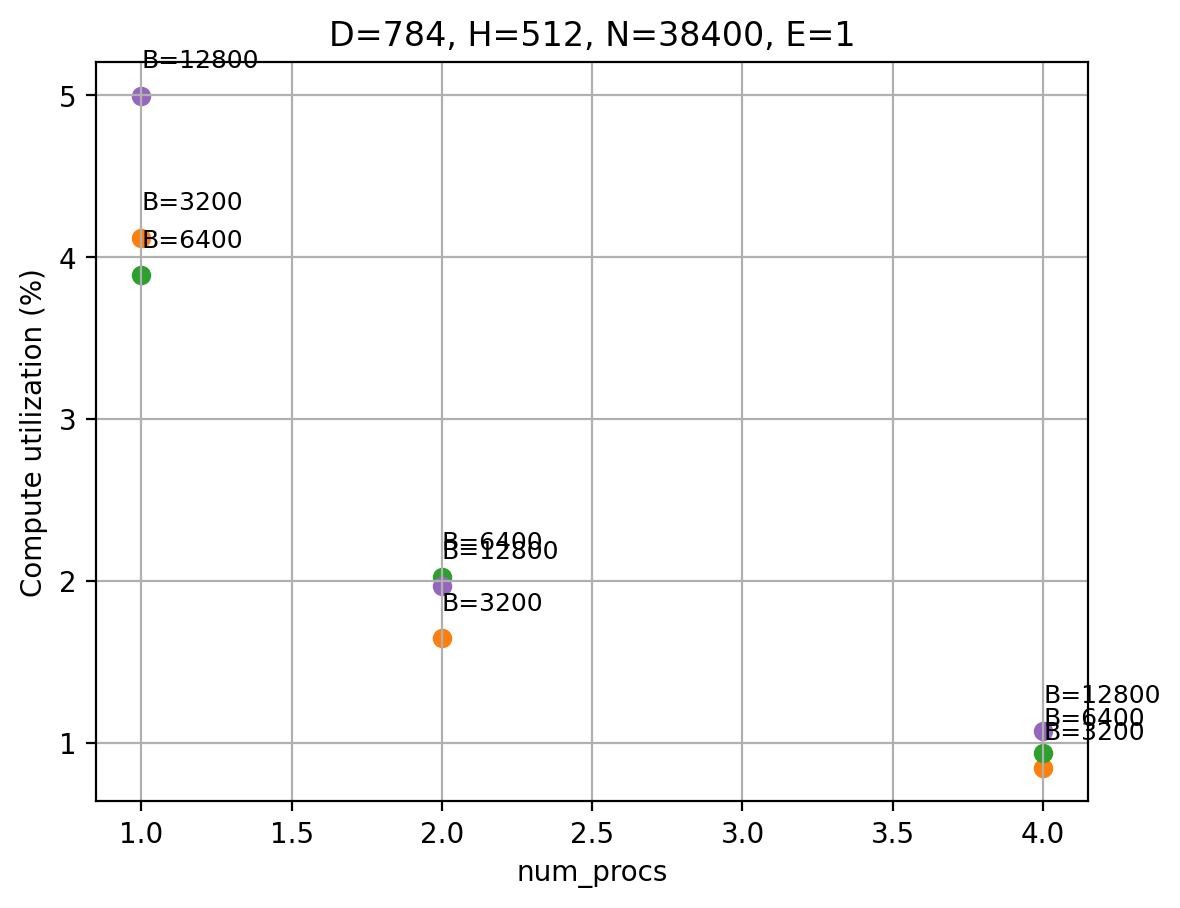

In [3]:
points = [
  [3200, 1, 0.0918224],
  [3200, 2, 0.114986],
  [3200, 4, 0.111955],
  [6400, 1, 0.0972862],
  [6400, 2, 0.0935801],
  [6400, 4, 0.100916],
  [12800, 1, 0.0757072],
  [12800, 2, 0.0960949],
  [12800, 4, 0.088025]
]

point_types = ['o', '^', None, 's']

for point in points:
  B, num_procs, dt = point
  num_batches = E * (N / B)

  FLOPs_per_batch = 4 * D * H * B
  total_FLOPs = FLOPs_per_batch * num_batches
  FLOPs_per_sec = total_FLOPs / dt
  utilization = FLOPs_per_sec / (num_procs * SINGLE_PRECISION_PERFORMANCE)
  plt.scatter(num_procs, utilization * 100, color=f"C{B // 3200}", )
  plt.annotate(f"B={B}", (num_procs, utilization * 100), 
               textcoords="offset points", xytext=(0,10), ha="left", fontsize=9)

plt.xlabel("num_procs")
plt.ylabel("Compute utilization (%)")
plt.title(f"D={D}, H={H}, N={N}, E={E}")
plt.grid(True)

plt.savefig("p2_1.png",dpi=600, bbox_inches="tight")
plt.show()

# Question 2.2

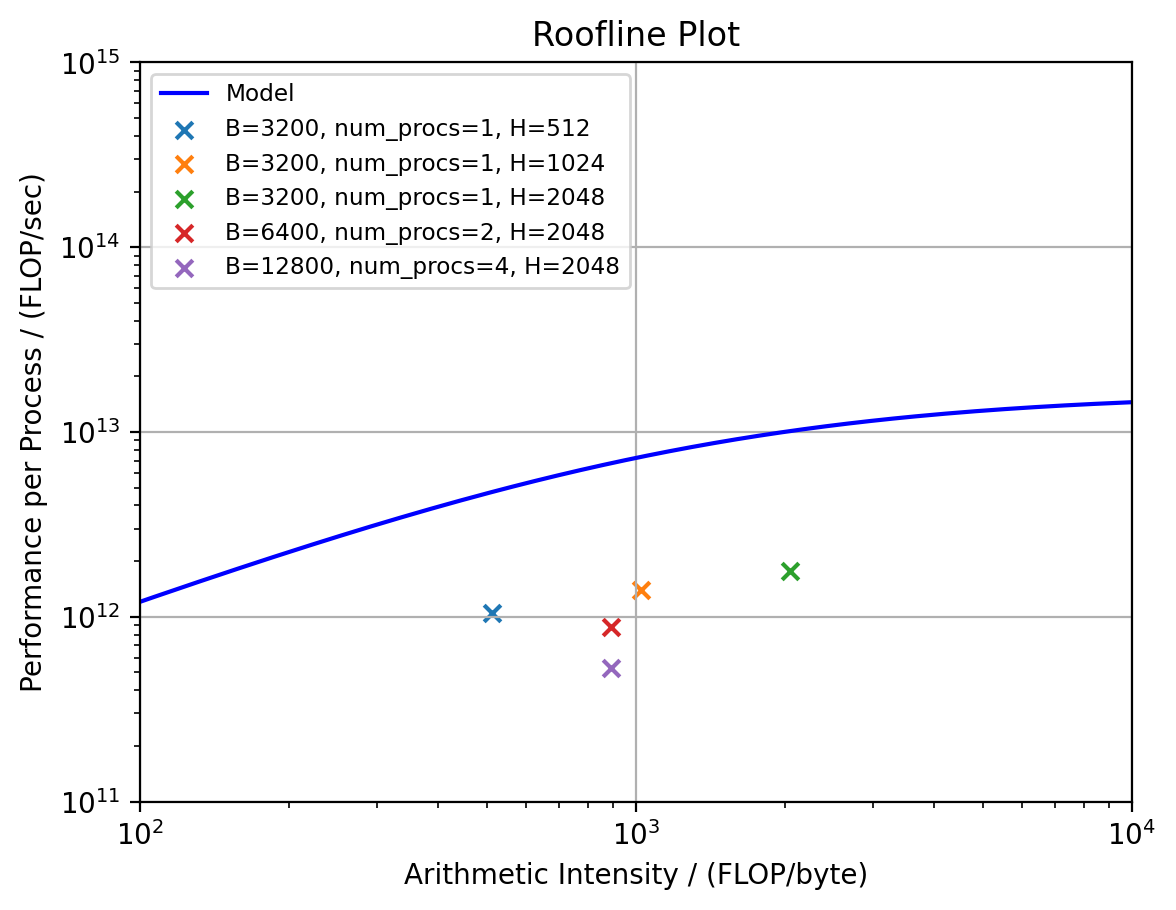

In [4]:
# For reliable results:
# Make sure flops per batch stays >= 1 Gflops.
# Keep B above 800 and H above 512.
# Check that numbers are stable across runs.
# Average over multiple runs.

FLOAT = True
SINGLE_PRECISION_PERFORMANCE = 16.3 * 10**12
MEMORY_BANDWIDTH = 13 * 10**9

# Define the range for x
x = np.logspace(0, 6, 400)

plt.plot(x, x / (x / SINGLE_PRECISION_PERFORMANCE + 1 / MEMORY_BANDWIDTH),
         'b', label="Model")

points = [
    [3200, 1, 512, 0.0587625],
    [3200, 1, 1024, 0.0885277],
    [3200, 1, 2048, 0.138829],
    [6400, 2, 2048, 0.139253],
    [12800, 4, 2048, 0.116152]
]

for i, point in enumerate(points):
    B, num_procs, H, dt = point

    # Fixed hyperparameters
    D = 784; C = 10
    N = 38400 # Number of training examples per epoch
    E = 1 # Number of epochs

    B_per_proc = B / num_procs
    num_batches = E * (N / B)
    dt_per_batch = dt / num_batches

    # All the below measures are per batch per process
    FLOPs = 4 * D * H * B_per_proc
    assert(FLOPs >= 1e9) # Results may not be meaningful otherwise
    FLOPs_per_sec = FLOPs / dt_per_batch

    bytes_per_real = 4 if FLOAT else 8
    # D*B_per_proc: host -> device input image
    # 2*(H*D + H): host <-> device gradients layer 1
    # 2*(C*H + C): host <-> device gradients layer 2
    # There's no cudaMemcpying of device gradients if we only have one process
    bytes_cudaMemcpy = (D*B_per_proc) + 2*(H*D + H) + 2*(C*H + C) \
                       if num_procs > 1 else (D*B)
    bytes_accessed = bytes_cudaMemcpy * bytes_per_real

    x_point = FLOPs / bytes_accessed
    # Approximately H*B_per_proc / (B_per_proc + 2*H) if num_procs > 1 else H
    # (if FLOAT)
    y_point = FLOPs_per_sec

    plt.scatter(x_point, y_point, color=f'C{i}', marker='x',
                label=f"B={B}, num_procs={num_procs}, H={H}")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Arithmetic Intensity / (FLOP/byte)')
plt.xlim(1e2, 1e4)
plt.ylabel('Performance per Process / (FLOP/sec)')
plt.ylim(1e11, 1e15)
plt.title('Roofline Plot')
plt.legend(loc='upper left', fontsize='small')
plt.grid(True)

plt.savefig('roofline.png',dpi=600,bbox_inches='tight')
plt.show()